In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime


from plotly import __version__
import cufflinks as cf

from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [2]:
%matplotlib inline

# Machine learning packages

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from math import sqrt

Using TensorFlow backend.
/Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version o

# Loading in data

In [4]:
# Import hourly pickups by Chicago Side
df_sides = pd.read_csv("hour_pickups_sides_final.csv")

df_sides["StartTime"] = pd.to_datetime(df_sides["StartTime"], 
                                       format="%d/%m/%Y %H:%M")

# set index
df_sides.set_index("StartTime", inplace=True)

df_sides.describe().astype(int)

,FNS,Ohara,NWS,NS,WS,CEN,SS,SWS,FSWS,FSES,is_holiday,is_weekend,season
count,10224,10224,10224,10224,10224,10224,10224,10224,10224,10224,10224,10224,10224
mean,88,40,32,199,218,308,68,49,22,15,0,0,1
std,46,30,16,135,126,196,36,23,11,8,0,0,1
min,0,0,0,0,0,0,0,0,0,0,0,0,0
25%,53,16,20,101,114,138,37,31,14,9,0,0,1
50%,87,36,32,169,219,305,70,51,23,15,0,0,2
75%,117,61,43,262,298,441,96,67,31,21,0,1,2
max,306,168,121,901,738,1079,210,141,80,53,1,1,3


In [5]:
# concert dataframe to floats
df_sides.astype(float)

,FNS,Ohara,NWS,NS,WS,CEN,SS,SWS,FSWS,FSES,is_holiday,is_weekend,season
StartTime,,,,,,,,,,,,,
2018-11-01 00:00:00,70.0,15.0,20.0,174.0,134.0,141.0,48.0,25.0,17.0,12.0,0.0,0.0,2.0
2018-11-01 01:00:00,46.0,5.0,9.0,200.0,94.0,103.0,22.0,16.0,17.0,7.0,0.0,0.0,2.0
2018-11-01 02:00:00,38.0,1.0,11.0,122.0,67.0,74.0,13.0,16.0,13.0,8.0,0.0,0.0,2.0
2018-11-01 03:00:00,19.0,1.0,15.0,73.0,51.0,63.0,9.0,13.0,15.0,8.0,0.0,0.0,2.0
2018-11-01 04:00:00,27.0,0.0,12.0,50.0,50.0,49.0,18.0,22.0,13.0,6.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,253.0,30.0,79.0,600.0,491.0,637.0,109.0,69.0,32.0,31.0,1.0,0.0,3.0
2019-12-31 20:00:00,279.0,20.0,82.0,695.0,540.0,647.0,110.0,106.0,47.0,42.0,1.0,0.0,3.0
2019-12-31 21:00:00,255.0,23.0,121.0,610.0,513.0,669.0,115.0,75.0,40.0,28.0,1.0,0.0,3.0


LSTM Multivariate demand prediction with weather data.
Should add weather data to the dataset. In other words, I am making a multivariate time series.

In [31]:
# Import hourly weather data

weather = pd.read_csv("Chicago Ohare hourly weather relevant data.csv")
weather["Date"] = pd.to_datetime(weather["Date"])
weather.drop("WeatherType", axis=1, inplace=True)
weather["Temperature"] = weather["Temperature"].astype("float32")
weather.set_index("Date", inplace=True)

In [32]:
weather.head()

,Precipitation,WindSpeed,Temperature
Date,,,
2018-11-01 00:00:00,0.0,9.66,9.0
2018-11-01 01:00:00,0.0,9.66,9.0
2018-11-01 02:00:00,0.0,9.66,9.0
2018-11-01 03:00:00,0.0,12.88,9.0
2018-11-01 04:00:00,0.0,16.10,9.0


In [33]:
df_sides_weather = df_sides.merge(weather, how="left", left_index=True, right_index=True)
df_sides_weather.head(3)


,FNS,Ohara,NWS,NS,WS,CEN,SS,SWS,FSWS,FSES,is_holiday,is_weekend,season,Precipitation,WindSpeed,Temperature
StartTime,,,,,,,,,,,,,,,,
2018-11-01 00:00:00,70,15,20,174,134,141,48,25,17,12,0,0,2,0.0,9.66,9.0
2018-11-01 01:00:00,46,5,9,200,94,103,22,16,17,7,0,0,2,0.0,9.66,9.0
2018-11-01 02:00:00,38,1,11,122,67,74,13,16,13,8,0,0,2,0.0,9.66,9.0


# Visualization of hourly pickups across sides

In [34]:
def visualize(data, colnumber, start_val, end_val):
    plt.figure(figsize=(10,5))
    plt.plot(data.iloc[start_val:end_val, colnumber])

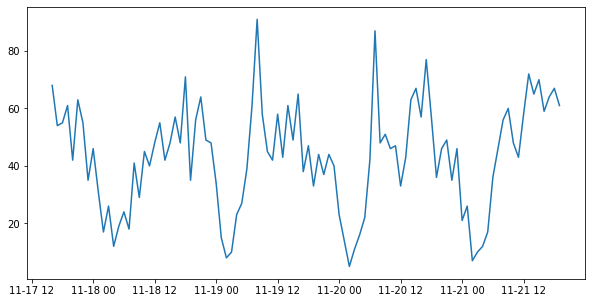

In [35]:
visualize(df_sides_weather, colnumber=7, start_val=400, end_val=500)

# LSTM data preperation

# Iterate over each column

In [36]:
df_sides.head()

,FNS,Ohara,NWS,NS,WS,CEN,SS,SWS,FSWS,FSES,is_holiday,is_weekend,season
StartTime,,,,,,,,,,,,,
2018-11-01 00:00:00,70,15,20,174,134,141,48,25,17,12,0,0,2
2018-11-01 01:00:00,46,5,9,200,94,103,22,16,17,7,0,0,2
2018-11-01 02:00:00,38,1,11,122,67,74,13,16,13,8,0,0,2
2018-11-01 03:00:00,19,1,15,73,51,63,9,13,15,8,0,0,2
2018-11-01 04:00:00,27,0,12,50,50,49,18,22,13,6,0,0,2


Functions to:
- Difference time series
- Inverse difference time series
- Create supervised time series
- Split time series
- Scale time series
- Create and fit LSTM model
- Make predictions
- Loop over X number of predictions to average RMSE
- Evaluate LSTM


In [42]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# specify number of lag hours
n_hours = 1
n_features = 1
n_obs = n_hours * n_features

def ts_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# n_feat = (len(supervised.columns)-1)

def split_data(data):
    # set fractions
    train_size = int(len(data) * 0.8)
    test_size = len(data) - train_size
    
    # split data into train and test sets
    train = data[0:train_size]
    test = data[train_size:]
    
    # split train and test further into x_train, y_train, x_test, y_test
    # when using multiple time steps
    x_train = train.iloc[:, :n_feat]
    x_test = test.iloc[:, :n_feat]
    
    # y_train = train.iloc[:, -n_features]
    # y_test = test.iloc[:, -n_features]
    
    y_train = train.iloc[:, -1]
    y_test = test.iloc[:, -1]
    
    # when using 1 time step
    # x_train = train.iloc[:, 0:4] # input for training set
    # x_test = test.iloc[:, 0:4] # input for test set

    # y_train = train.iloc[:, 4] # output for training set
    # y_test = test.iloc[:, 4] # output for test set
    
    # convert into numpy arrays
    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()
    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    # reshape to make numpy arrays into 2D
    # x_train = x_train.reshape(-1,1)
    # x_test = x_test.reshape(-1,1)
    y_train = y_train.reshape(-1,1)
    y_test = y_test.reshape(-1,1)
    
    return train, test, x_train, x_test, y_train, y_test

def scale(x_train, x_test, y_train, y_test):
    # fit scaler
    x_scaler = MinMaxScaler(feature_range=(-1,1))
    x_scaler = x_scaler.fit(x_train)
    y_scaler = MinMaxScaler(feature_range=(-1,1))
    y_scaler = y_scaler.fit(y_train)
    
    x_train_scaled = x_scaler.transform(x_train)
    x_test_scaled = x_scaler.transform(x_test)
    y_train_scaled = y_scaler.transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)
    
    x_train_scaled = np.reshape(x_train_scaled, (x_train_scaled.shape[0], n_hours, n_feat))
    x_test_scaled = np.reshape(x_test_scaled, (x_test_scaled.shape[0], n_hours, n_feat))
    
    return x_scaler, y_scaler, x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled

def fit_lstm(x_train_scaled, y_train_scaled, batch, ep, neurons_lstm, neuron_dense):
    model = Sequential()
    model.add(LSTM(units=neurons_lstm, input_shape=(x_train_scaled.shape[1], x_train_scaled.shape[2])))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=neuron_dense))
    model.compile(loss="mean_squared_error", 
                  optimizer="adam",
                 )
    
    model.fit(x_train_scaled, 
                        y_train_scaled, 
                        epochs=ep, 
                        batch_size=batch, 
                        validation_split=0.1, 
                        verbose=0, 
                        shuffle=False)
    return model

def predictions_lstm(x_test_scaled, y_test):
    # get predictions
    test_pred = model.predict(x_test_scaled)
    
    # reverse transform predictions
    test_pred_inv = y_scaler.inverse_transform(test_pred)
    
    # reverse differencing predictions
    inverted_pred = list()
    for i in range(len(test_pred_inv)):
        value = inverse_difference(df_sides[key], test_pred_inv[i], len(test_pred_inv)-i)
        inverted_pred.append(value)
    inverted_pred = pd.DataFrame(inverted_pred)
    
    # reverse differencing y_test
    inverted_ytest = list()
    for i in range(len(y_test)):
        value = inverse_difference(df_sides[key], y_test[i], len(y_test)+1-i)
        inverted_ytest.append(value)
    inverted_ytest = pd.DataFrame(inverted_ytest)
    
    # create single dataframe with predictions (1) and expected values (2)
    predictions = np.concatenate((inverted_pred, inverted_ytest), axis=1)
    predictions = pd.DataFrame(predictions)
    
    return test_pred, test_pred_inv, predictions

def evaluate_lstm(predictions):
    # print RMSE
    rmse = np.sqrt(mean_squared_error(predictions[0], predictions[1]))
    mse_error = rmse**2
#     mean_value = predictions.iloc[:,1].mean()
    print("Pred MSE:", mse_error)
    print('Pred RMSE: %.3f' % rmse)
#     print("Test mean value:", mean_value)
    
    
    # print min max values of predictions and actual values.
    print("Min. value pred:", predictions[0].min())
    print("Max. value pred:", predictions[0].max())

    print("Min. value test:", predictions[1].min())
    print("Max. value test:", predictions[1].max())
    
    # plot predictions vs actual values
#     plt.plot(predictions.iloc[start_val:end_val, 0])
#     plt.plot(predictions.iloc[start_val:end_val, 1])
    
    return rmse

# repeats = 3
# error_scores = list()

# for i in range(repeats):
#     # fit the model
#     model, history = fit_lstm(x_train_scaled, 
#                               y_train_scaled, 
#                               batch=100, ep=10, 
#                               neurons_lstm=5, 
#                               neuron_dense=1)
#     # make predictions
#     predictions = predictions_lstm(x_test_scaled, y_test)
#     # report performance
#     rmse = np.sqrt(mean_squared_error(predictions[0], predictions[1]))
#     print('%d) Test RMSE: %.3f' % (i+1, rmse))
#     error_scores.append(rmse)

#     # summarize the results
#     results = pd.DataFrame()
#     results["rmse"] = error_scores
#     print(results.head())
#     print(results.describe())
#     results.boxplot()


In [43]:
df_test = df_sides.iloc[:, :2]
df_test

,FNS,Ohara
StartTime,,
2018-11-01 00:00:00,70,15
2018-11-01 01:00:00,46,5
2018-11-01 02:00:00,38,1
2018-11-01 03:00:00,19,1
2018-11-01 04:00:00,27,0
...,...,...
2019-12-31 19:00:00,253,30
2019-12-31 20:00:00,279,20
2019-12-31 21:00:00,255,23


Order of getting LSTM predictions and RMSE
- differencing time series
- making time series supervised
- split supervised time series
- scaling supervised time series
- train and fit model
- get predictions
- evaluate

enumerate(iterable, start) returns a tuple object with a counter to the iterable

In [44]:
diff_dic = {}

for count, item in enumerate(df_test[["FNS", "Ohara"]]):
    diff = difference(df_test[:][item], 1)
    diff_dic[item] = diff

diff_df = pd.DataFrame(diff_dic)


In [46]:
df_sides_weather.head(2)

,FNS,Ohara,NWS,NS,WS,CEN,SS,SWS,FSWS,FSES,is_holiday,is_weekend,season,Precipitation,WindSpeed,Temperature
StartTime,,,,,,,,,,,,,,,,
2018-11-01 00:00:00,70,15,20,174,134,141,48,25,17,12,0,0,2,0.0,9.66,9.0
2018-11-01 01:00:00,46,5,9,200,94,103,22,16,17,7,0,0,2,0.0,9.66,9.0


In [55]:
df_sides_weather.iloc[2:, 10:].head(2)

,is_holiday,is_weekend,season,Precipitation,WindSpeed,Temperature
StartTime,,,,,,
2018-11-01 02:00:00,0,0,2,0.0,9.66,9.0
2018-11-01 03:00:00,0,0,2,0.0,12.88,9.0


1) Test RMSE: 3.192
2) Test RMSE: 3.451
3) Test RMSE: 2.874
1) Test RMSE: 3.109
2) Test RMSE: 3.219
3) Test RMSE: 3.273
        FNS     Ohara
0  3.191597  3.109448
1  3.451417  3.219048
2  2.874079  3.273080
            FNS     Ohara
count  3.000000  3.000000
mean   3.172364  3.200526
std    0.289149  0.083374
min    2.874079  3.109448
25%    3.032838  3.164248
50%    3.191597  3.219048
75%    3.321507  3.246064
max    3.451417  3.273080


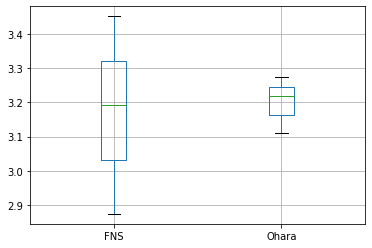

In [59]:
# difference each time series and creating differenced df
diff_dic = {}

for count, item in enumerate(df_test.columns):
    diff = difference(df_test[:][item], 1)
    diff_dic[item] = diff

diff_df = pd.DataFrame(diff_dic)

# making time series supervised
supervised_dic = {}

for col in diff_df:
    supervised = ts_supervised(diff_df[[col]], 1)
    supervised_dic[col] = supervised
    
# merge supervised time series with weather data and holidays
supervised_remerged_dic = {}

for key in supervised_dic:
    supervised_remerged = pd.concat([df_sides_weather.iloc[2:, 10:].set_index(supervised_dic[key].index), supervised_dic[key]], axis=1)
    supervised_remerged_dic[key] = supervised_remerged    

n_feat = (len(supervised_dic["FNS"].columns)-1)

# split supervised time series
train_dic = {}
test_dic = {}
x_train_dic = {}
x_test_dic = {}
y_train_dic = {}
y_test_dic = {}

for key in supervised_dic:
    train, test, x_train, x_test, y_train, y_test = split_data(supervised_dic[key])
    train_dic[key], test_dic[key], x_train_dic[key], x_test_dic[key], y_train_dic[key], y_test_dic[key] = train, test, x_train, x_test, y_train, y_test

# scaling supervised time series
x_scaler_dic = {}
y_scaler_dic = {}
x_train_scaled_dic = {}
x_test_scaled_dic = {}
y_train_scaled_dic = {}
y_test_scaled_dic = {}

for key in x_train_dic:
    x_scaler, y_scaler, x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = scale(x_train_dic[key], x_test_dic[key], y_train_dic[key], y_test_dic[key])
    x_scaler_dic[key], y_scaler_dic[key], x_train_scaled_dic[key], x_test_scaled_dic[key], y_train_scaled_dic[key], y_test_scaled_dic[key] = x_scaler, y_scaler, x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled
    
# train and fit model (note: no history object)
model_dic = {}
history_dic = {}

for key in x_train_scaled_dic:
    model = fit_lstm(x_train_scaled_dic[key], 
                              y_train_scaled_dic[key], 
                              batch=100, ep=50, 
                              neurons_lstm=5, 
                              neuron_dense=1)
    model_dic[key] = model

    
# get predictions and evaluate performance of each neighborhood ONCE.
# test_pred_dic = {}
# test_pred_inv_dic = {}
# predictions_dic = {}

# for key in x_test_scaled_dic:
#     test_pred, test_pred_inv, predictions = predictions_lstm(x_test_scaled_dic[key], y_test_dic[key])
#     test_pred_dic[key], test_pred_inv_dic[key], predictions_dic[key] = test_pred, test_pred_inv_dic, predictions

# rmse_dic = {}

# # evaluate performance
# for key in predictions_dic:
#     rmse = evaluate_lstm(predictions_dic[key])
#     rmse_dic[key] = rmse


# repeat predictions and evaluate performance of each neighborhood
repeats = 3
error_scores_dic = {}
predictions_dic = {}

for key in x_test_scaled_dic:
    error_scores = list()
    for i in range(repeats):
        # fit the model
        model = fit_lstm(x_train_scaled, 
                                  y_train_scaled, 
                                  batch=100, ep=10, 
                                  neurons_lstm=5, 
                                  neuron_dense=1)
        # make predictions
        predictions = predictions_lstm(x_test_scaled_dic[key], y_test_dic[key])
        predictions_dic[key] = predictions
        # report performance for each Chicago Side
        rmse = np.sqrt(mean_squared_error(predictions[0], predictions[1]))
        print('%d) Test RMSE: %.3f' % (i+1, rmse))
        error_scores.append(rmse)
        error_scores_dic[key] = error_scores

# summarize the results
results_rmse = pd.DataFrame(error_scores_dic)
print(results_rmse.head())
print(results_rmse.describe())
results_rmse.boxplot()


In [60]:
# plot predictions vs actual values
plt.plot(predictions_dic["Ohara"].iloc[100:200, 0])
plt.plot(predictions_dic["Ohara"].iloc[100:200, 1])

AttributeError: 'tuple' object has no attribute 'iloc'